# Employee Code Production Analyser

*This notebook is designed to be usable by non-technical operations employees of AffectusAI.*

## How to use:

1. Grab personal access token from Github
2. Run the first two cells
3. Input access token in cell 3 and run cell 3
4. Input the outputted data from cell 3 into contributors array
5. Run cell 4


In [2]:
!pip install requests pandas seaborn

In [ ]:
# Import required libraries
import requests
import base64
from datetime import datetime, timezone
import os
from typing import Dict, List, Set, Tuple
from time import sleep
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

class OrgContributionAnalyzer:
    def __init__(self, token: str, org: str):
        """
        Initialize the analyzer with GitHub token and organization name.

        Args:
            token: GitHub personal access token
            org: Organization name
        """
        self.token = token
        self.org = org
        self.headers = {
            'Authorization': f'token {token}',
            'Accept': 'application/vnd.github.v3+json'
        }
        self.base_url = 'https://api.github.com'
        self.rate_limit_remaining = float('inf')
        self.rate_limit_reset = 0
        self._update_rate_limit()

        # Dictionary to map identities to canonical names
        self.identity_mapping = {
            'mozartpmb': 'Peter Brown',
            'pete@Peters-MacBook-Pro.local': 'Peter Brown',
            'pete@Peters-MBP.rochester.rr.com': 'Peter Brown',
            'raghav_menon@yahoo.com': 'Raghav Menon',
            'raghavmenon@affectusai.com': 'Raghav Menon',
            'RMenon': 'Raghav Menon'
        }

    # [Previous methods remain the same until analyze_period]

    def analyze_period(self, start_date: str, end_date: str) -> Dict:
        """Analyze all contributions in the organization for a specific period."""
        print(f"\nAnalyzing period: {start_date} to {end_date}")

        contributors = defaultdict(lambda: {
            'identifiers': set(),
            'stats': defaultdict(lambda: {'additions': 0, 'deletions': 0, 'commits': 0}),
            'total': {'additions': 0, 'deletions': 0, 'commits': 0}
        })

        repos = self.get_org_repos()

        for repo_data in repos:
            repo = repo_data['name']
            print(f"\nProcessing {repo}...")

            commits = self.get_commits_for_period(repo, start_date, end_date)

            for commit in commits:
                try:
                    self._handle_rate_limit()

                    commit_response = requests.get(
                        commit.get('url', ''),
                        headers=self.headers
                    )
                    commit_response.raise_for_status()
                    commit_data = commit_response.json()

                    github_username = (commit.get('author') or {}).get('login', 'unknown')
                    commit_info = commit_data.get('commit', {})
                    author_info = commit_info.get('author', {})
                    author_email = author_info.get('email', 'unknown')
                    author_name = author_info.get('name', 'unknown')

                    # Map to canonical name if available
                    contributor_key = self.identity_mapping.get(github_username) or \
                                    self.identity_mapping.get(author_email) or \
                                    self.identity_mapping.get(author_name) or \
                                    github_username
                    if contributor_key == 'unknown':
                        contributor_key = author_name

                    # Store identifiers
                    if github_username != 'unknown':
                        contributors[contributor_key]['identifiers'].add(('github', github_username))
                    if author_email != 'unknown':
                        contributors[contributor_key]['identifiers'].add(('email', author_email))
                    if author_name != 'unknown':
                        contributors[contributor_key]['identifiers'].add(('name', author_name))

                    additions = 0
                    deletions = 0

                    for file in commit_data.get('files', []):
                        if self._is_code_file(file.get('filename', '')):
                            additions += file.get('additions', 0)
                            deletions += file.get('deletions', 0)

                    contributors[contributor_key]['stats'][repo]['additions'] += additions
                    contributors[contributor_key]['stats'][repo]['deletions'] += deletions
                    contributors[contributor_key]['stats'][repo]['commits'] += 1

                    contributors[contributor_key]['total']['additions'] += additions
                    contributors[contributor_key]['total']['deletions'] += deletions
                    contributors[contributor_key]['total']['commits'] += 1

                except Exception as e:
                    print(f"Error processing commit {commit.get('sha', 'unknown')}: {e}")
                    continue

        return dict(contributors)

def visualize_contributions(period1_results: Dict, period2_results: Dict,
                          period1_name: str, period2_name: str):
    """Create visualizations for the contribution data."""
    # Set the style
    plt.style.use('seaborn')

    # Prepare data
    contributors = set()
    for p in [period1_results, period2_results]:
        contributors.update(p.keys())

    data = []
    for contributor in sorted(contributors):
        p1_stats = period1_results.get(contributor, {}).get('total', {'additions': 0, 'deletions': 0, 'commits': 0})
        p2_stats = period2_results.get(contributor, {}).get('total', {'additions': 0, 'deletions': 0, 'commits': 0})

        data.append({
            'Contributor': contributor,
            'P1 Additions': p1_stats['additions'],
            'P1 Deletions': p1_stats['deletions'],
            'P1 Commits': p1_stats['commits'],
            'P2 Additions': p2_stats['additions'],
            'P2 Deletions': p2_stats['deletions'],
            'P2 Commits': p2_stats['commits']
        })

    df = pd.DataFrame(data)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot 1: Code Changes
    width = 0.35
    x = np.arange(len(df))

    ax1.bar(x - width/2, df['P1 Additions'], width, label=f'{period1_name} Additions', color='#2196F3')
    ax1.bar(x - width/2, df['P1 Deletions'], width, bottom=df['P1 Additions'],
            label=f'{period1_name} Deletions', color='#90CAF9')
    ax1.bar(x + width/2, df['P2 Additions'], width, label=f'{period2_name} Additions', color='#4CAF50')
    ax1.bar(x + width/2, df['P2 Deletions'], width, bottom=df['P2 Additions'],
            label=f'{period2_name} Deletions', color='#A5D6A7')

    ax1.set_ylabel('Lines of Code')
    ax1.set_title('Code Changes by Contributor')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['Contributor'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Commits
    ax2.bar(x - width/2, df['P1 Commits'], width, label=f'{period1_name}', color='#2196F3')
    ax2.bar(x + width/2, df['P2 Commits'], width, label=f'{period2_name}', color='#4CAF50')

    ax2.set_ylabel('Number of Commits')
    ax2.set_title('Commits by Contributor')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['Contributor'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig, df

def analyze_github_contributions(token: str, org: str,
                               period1_start: str, period1_end: str,
                               period2_start: str, period2_end: str):
    """Main function to analyze and visualize GitHub contributions."""

    analyzer = OrgContributionAnalyzer(token, org)

    try:
        # Analyze both periods
        print("\nAnalyzing first period...")
        period1_results = analyzer.analyze_period(period1_start, period1_end)

        print("\nAnalyzing second period...")
        period2_results = analyzer.analyze_period(period2_start, period2_end)

        # Create visualizations
        fig, df = visualize_contributions(
            period1_results,
            period2_results,
            f"{period1_start} to {period1_end}",
            f"{period2_start} to {period2_end}"
        )

        # Print summary statistics
        print("\nSummary Statistics:")
        print("=" * 80)
        for _, row in df.iterrows():
            p1_total = row['P1 Additions'] + row['P1 Deletions']
            p2_total = row['P2 Additions'] + row['P2 Deletions']

            print(f"\n{row['Contributor']}:")
            print(f"Period 1: {p1_total:,} lines changed ({row['P1 Commits']} commits)")
            print(f"Period 2: {p2_total:,} lines changed ({row['P2 Commits']} commits)")

            if p1_total > 0:
                change = ((p2_total - p1_total) / p1_total) * 100
                print(f"Change in activity: {change:+.1f}%")
            elif p2_total > 0:
                print("Change in activity: +∞% (no activity in Period 1)")
            else:
                print("No activity in either period")

        return fig, df

    except requests.exceptions.RequestException as e:
        print(f"Error accessing GitHub API: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [ ]:
import os
os.environ['GITHUB_TOKEN'] = 'your_token_here'  # Or use notebook secrets management

fig, df = analyze_github_contributions(
    token=os.getenv('GITHUB_TOKEN'),
    org='AffectusAI',
    period1_start='2024-09-17',
    period1_end='2024-10-04',
    period2_start='2024-10-05',
    period2_end='2024-10-17'
)

plt.show()

##**Enter output below for visualization**

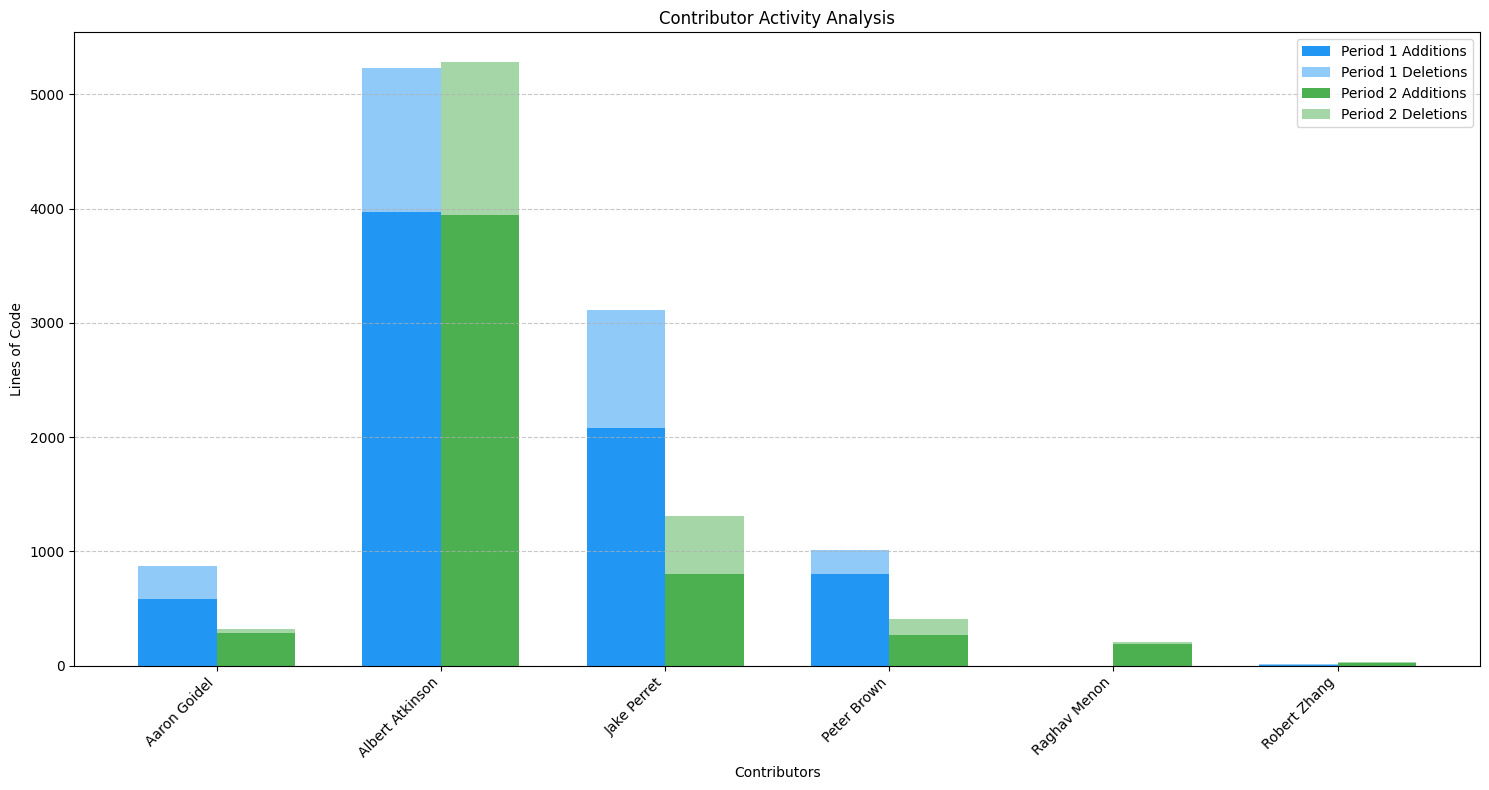


Summary Statistics:
--------------------------------------------------------------------------------

Aaron Goidel:
Period 1: 870 lines changed (9 commits)
Period 2: 322 lines changed (6 commits)
Change: -63.0%

Albert Atkinson:
Period 1: 5,232 lines changed (29 commits)
Period 2: 5,278 lines changed (42 commits)
Change: +0.9%

Jake Perret:
Period 1: 3,109 lines changed (79 commits)
Period 2: 1,308 lines changed (44 commits)
Change: -57.9%

Peter Brown:
Period 1: 1,015 lines changed (6 commits)
Period 2: 411 lines changed (4 commits)
Change: -59.5%

Raghav Menon:
Period 1: 0 lines changed (0 commits)
Period 2: 208 lines changed (6 commits)
Change: +∞% (no activity in Period 1)

Robert Zhang:
Period 1: 17 lines changed (3 commits)
Period 2: 28 lines changed (2 commits)
Change: +64.7%


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
contributors = {
    'Aaron Goidel': {
        'period1': {'additions': 585, 'deletions': 285, 'commits': 9},
        'period2': {'additions': 287, 'deletions': 35, 'commits': 6}
    },
    'Albert Atkinson': {
        'period1': {'additions': 3967, 'deletions': 1265, 'commits': 29},
        'period2': {'additions': 3946, 'deletions': 1332, 'commits': 42}
    },
    'Jake Perret': {
        'period1': {'additions': 2079, 'deletions': 1030, 'commits': 79},
        'period2': {'additions': 804, 'deletions': 504, 'commits': 44}
    },
    'Peter Brown': {
        'period1': {'additions': 801, 'deletions': 214, 'commits': 6},
        'period2': {'additions': 265, 'deletions': 146, 'commits': 4}
    },
    'Raghav Menon': {
        'period1': {'additions': 0, 'deletions': 0, 'commits': 0},
        'period2': {'additions': 188, 'deletions': 20, 'commits': 6}
    },
    'Robert Zhang': {
        'period1': {'additions': 7, 'deletions': 10, 'commits': 3},
        'period2': {'additions': 25, 'deletions': 3, 'commits': 2}
    }
}

# Create lists for plotting
names = list(contributors.keys())
p1_additions = [contributors[name]['period1']['additions'] for name in names]
p1_deletions = [contributors[name]['period1']['deletions'] for name in names]
p2_additions = [contributors[name]['period2']['additions'] for name in names]
p2_deletions = [contributors[name]['period2']['deletions'] for name in names]

# Set up the plot
plt.figure(figsize=(15, 8))
x = np.arange(len(names))
width = 0.35

# Create bars
plt.bar(x - width/2, p1_additions, width, label='Period 1 Additions', color='#2196F3')
plt.bar(x - width/2, p1_deletions, width, bottom=p1_additions, label='Period 1 Deletions', color='#90CAF9')
plt.bar(x + width/2, p2_additions, width, label='Period 2 Additions', color='#4CAF50')
plt.bar(x + width/2, p2_deletions, width, bottom=p2_additions, label='Period 2 Deletions', color='#A5D6A7')

# Customize the plot
plt.xlabel('Contributors')
plt.ylabel('Lines of Code')
plt.title('Contributor Activity Analysis')
plt.xticks(x, names, rotation=45, ha='right')
plt.legend()

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 80)
for name in names:
    p1_total = contributors[name]['period1']['additions'] + contributors[name]['period1']['deletions']
    p2_total = contributors[name]['period2']['additions'] + contributors[name]['period2']['deletions']
    p1_commits = contributors[name]['period1']['commits']
    p2_commits = contributors[name]['period2']['commits']

    print(f"\n{name}:")
    print(f"Period 1: {p1_total:,} lines changed ({p1_commits} commits)")
    print(f"Period 2: {p2_total:,} lines changed ({p2_commits} commits)")
    if p1_total > 0:
        change = ((p2_total - p1_total) / p1_total) * 100
        print(f"Change: {change:+.1f}%")
    elif p2_total > 0:
        print("Change: +∞% (no activity in Period 1)")
    else:
        print("No activity in either period")